In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter

Get the worst-case (smallest) spot size

/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/F1_to_K3_config_3_field_1_results.npz Parameter('x_mean', value=0.021351631120918778) Parameter('y_mean', value=0.0050471619399737625) 0.07642846301083601 0.13464328810077186 Parameter('theta', value=0.0375996975089838)
/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/F1_to_K3_config_3_field_8_results.npz Parameter('x_mean', value=-0.13633014574705563) Parameter('y_mean', value=-0.01321701562715333) 0.08156954402916915 0.11360507835349107 Parameter('theta', value=-0.4443504581902328)
/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/K2_to_K1_config_3_field_1_results.npz Parameter('x_mean', value=0.030527924776154715) Parameter('y_mean', value=-0.002458543976127726) 0.04942303948461134 0.08772866111352143 Parameter('theta', value=0.02309965834117356)
/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/K2_to_K1_config_3_field_8_results.npz Parameter('x_mean', value=0.200075638

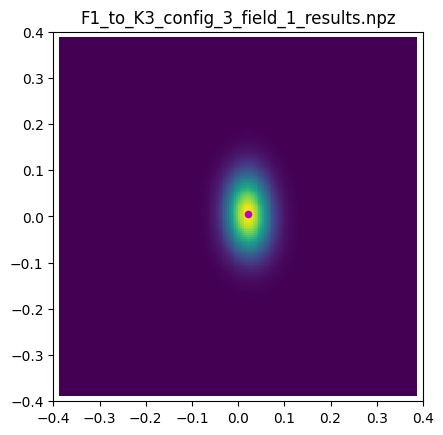

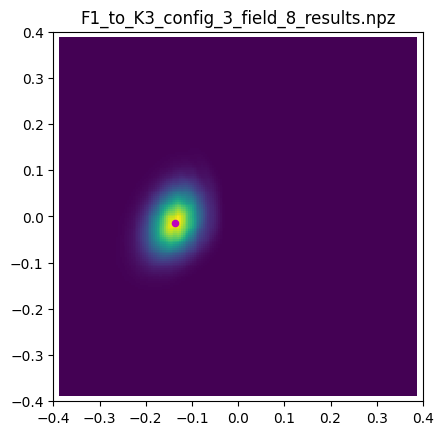

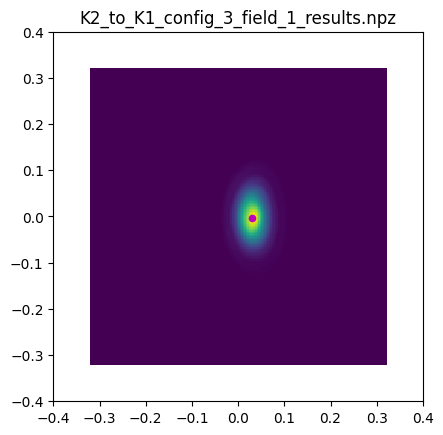

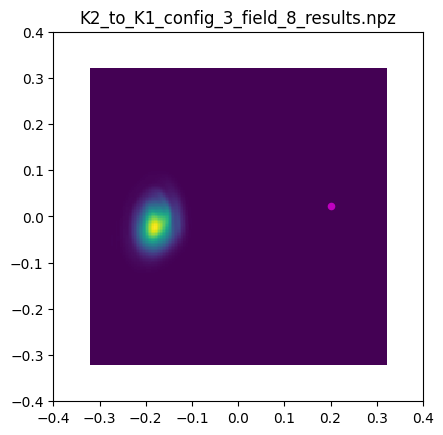

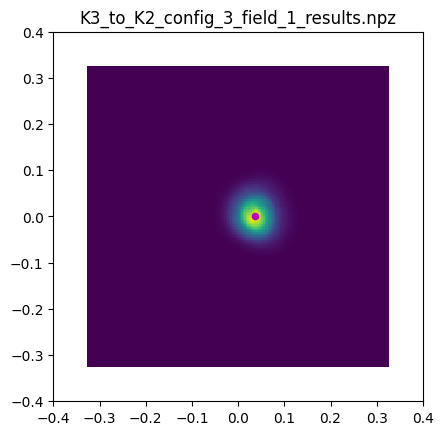

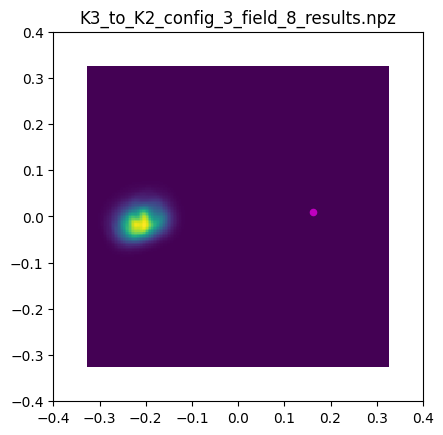

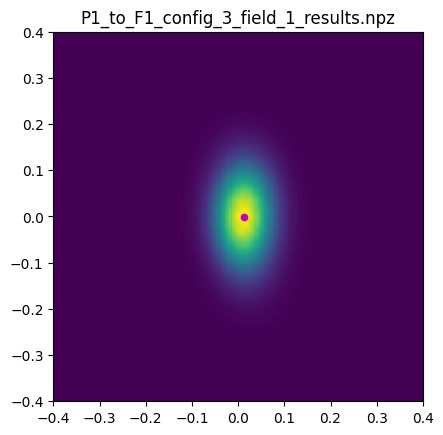

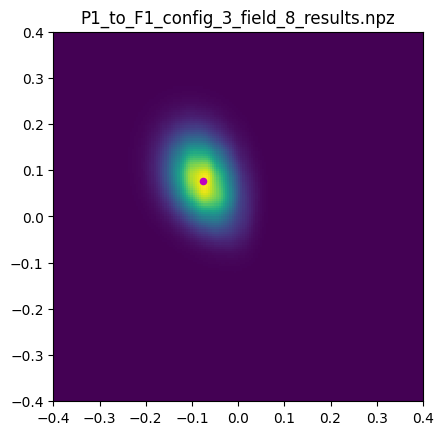

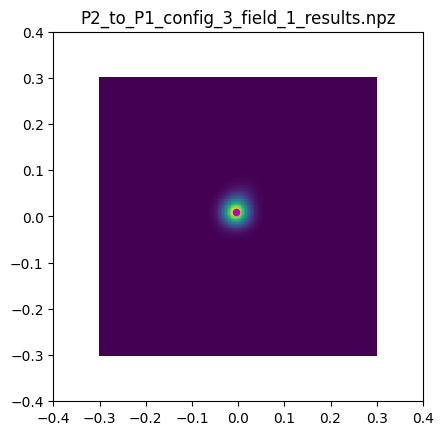

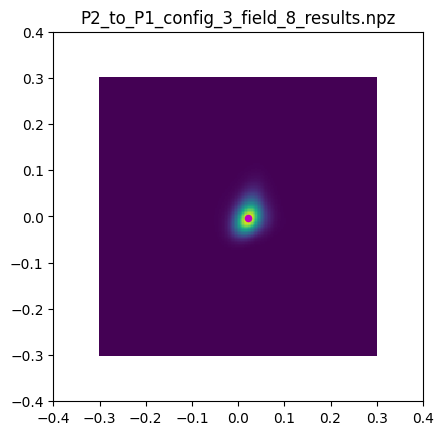

In [2]:
files = glob.glob('/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/*results.npz')
smallest_x = np.inf
smallest_y = np.inf
smallest_file_x = ''
smallest_file_y = ''
for file in sorted(files):
    if ("FLANGE" in file) or ("arb" in file):
        continue
    data = np.load(file)
    xx = data['xx_img']
    yy = data['yy_img']
    img = np.abs(data['fresnel_img']) ** 2.

    fig, ax = plt.subplots()
    ax.pcolormesh(xx, yy, img)
    ax.set_xlim(-0.4, 0.4)
    ax.set_ylim(-0.4, 0.4)
    ax.set_aspect('equal')
    ax.set_title(os.path.basename(file))

    # fit a 2D Gaussian to data and extract fit params
    p_init = Gaussian2D(
        amplitude=img.max(),
        x_mean=0.,
        y_mean=0.,
        x_stddev=0.1,
        y_stddev=0.1
    )
    fit_p = LevMarLSQFitter()
    p = fit_p(p_init, xx, yy, img)
    print(file, p.x_mean, p.y_mean, p.x_fwhm, p.y_fwhm, p.theta)
    ax.scatter(p.x_mean.value, p.y_mean.value, s=20, color='m')
    if p.x_fwhm < smallest_x and p.x_fwhm > 1e-9:
        smallest_x = p.x_fwhm
        smallest_file_x = file
    if p.x_fwhm < smallest_y and p.y_fwhm > 1e-9:
        smallest_y = p.y_fwhm
        smallest_file_y = file
print(os.path.basename(smallest_file_x), smallest_x)
print(os.path.basename(smallest_file_y), smallest_y)